In [41]:
import pandas as pd
import json

with open('result.json') as res:
    f = res.read()
    jf = json.loads(f)
    df = pd.DataFrame(jf['messages'])

df.count()

id                     127219
type                   127219
date                   127219
date_unixtime          127219
actor                     279
actor_id                  291
action                    291
title                      22
text                   127219
photo                    2037
width                    5055
height                   5055
from                   126841
from_id                126928
forwarded_from            707
saved_from                118
reply_to_message_id     77729
edited                   5790
edited_unixtime          5790
file                     3154
thumbnail                2900
media_type               3083
sticker_emoji            2544
mime_type                 582
duration_seconds          538
poll                        7
members                   271
via_bot                   179
message_id                 17
performer                  21
dtype: int64

<AxesSubplot:>

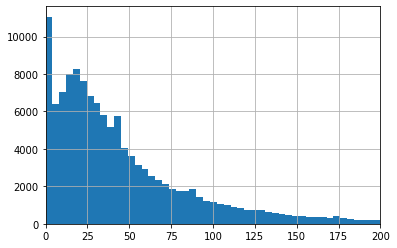

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.set_xlim(0, 200)
df['text'].apply(len).hist(bins=1000)

In [3]:
syr = df.loc[(df['from'] == 'Сырок') | (df['from'] == 'Дмитрий Sleeping Shaman'), 'text']
syrock = syr.loc[syr.apply(type) == str]
print(len(syr))
print(len(syrock))
text = syrock.astype('string').str.cat(sep=' ')
print(len(text))

11341
11203
456534


In [4]:
chat = df.loc[df['text'].apply(type) == str, 'text']
chat = df.loc[df['text'].apply(len) != 0, 'text']
chat_text = chat.astype('string').str.cat(sep=' ')
len(chat_text)

7787377

In [5]:
import torch

train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

No GPU available, training on CPU; consider making n_epochs very small.


In [6]:
import torch.nn as nn
import matplotlib
import numpy as np
import nltk

%matplotlib inline

In [7]:
torch.autograd.set_detect_anomaly(True)

In [8]:
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.dropout = nn.Dropout(0.1)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1,-1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.dropout(output)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [9]:
import string

all_characters = 'абвгдеёжзийклмнопрстуфхцчшщэюяыьъА\
БВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯЫЬЪ123456789,. !?:;+-*\qwertyuiopasdfghjklzxcvbnm()'
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            # print(f"trouble character: {string[c]}")
            pass
    return Variable(tensor)

In [10]:
import random

chunk_len = 32
text_len = len(chat_text)

def random_chunk():
    start_index = random.randint(0, text_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return chat_text[start_index:end_index]

def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [11]:
def evaluate(prime_str='а', predict_len=64, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
#         # Sample from the network as a multinomial distribution
#         output_dist = output.data.view(-1).div(temperature).exp()
#         top_i = torch.multinomial(output_dist, 1)[0]
    
        # Add predicted character to string and use as next input
        predicted_char = all_characters[topi]
        predicted += predicted_char
        inp = char_tensor(predicted_char)
    return predicted

In [12]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].view(-1))

    loss.backward()
    decoder_optimizer.step()

    return loss.data / chunk_len

In [42]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 1
lr = 0.001

n_characters = len(all_characters)

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
# decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(decoder_optimizer, gamma=0.95)

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('а', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 36s (100 5%) 3.1439]
ане помо помо помо посе помомо посему пото помо помого помо поромомо помомо помо помо посемо поромомо 

 14s (200 10%) 2.9543]
а во то во во во во во в во в во во во во во во во во во в во во во во во во во во во то во во то во  

 54s (300 15%) 2.7394]
а поро поросто по прото пото сто сто поро поросто то по пото порото по поросто поросто посто пото пор 

 31s (400 20%) 2.5912]
а сони не не сели слени слени не соне он не сленини и сельный сони не не сле не не слени не слен и он 

 7s (500 25%) 2.7917]
а это изанать и стать и разамать и изанать и и стать на стать и иза изаза стать и стать и стать стама 

 45s (600 30%) 2.7843]
а ка кать сто ра кать сото то то так и на та ка ка то то то кать сото так и кать то то котора не то к 

 22s (700 35%) 2.8266]
а в слена в слеть смовно в слени в слеть в стому в смотове слена в стовы в сто в слени пото в стом в  

 9s (800 40%) 3.1030]
а та на та корат в та корати на та так та так то коростат в так та то кат так так так так т

In [43]:
print(evaluate('м', 50, 0.5), '\n')

м собо в кото обы в кото кото обо в кото кото кон т 



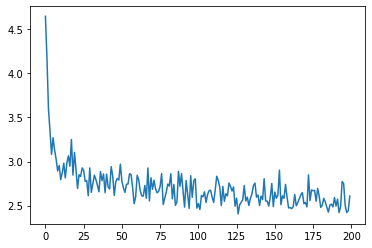

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [45]:
EPOCH = 2001
LOSS = all_losses[-1]
PATH = "checkpoint1_SGD.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': decoder.state_dict(),
            'optimizer_state_dict': decoder_optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)


In [49]:
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=0.0005, momentum=0.9)
for epoch in range(EPOCH, EPOCH + 2000 + 1):
    loss = train(*random_training_set())       
    loss_avg += loss
    EPOCH += 1

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Ма', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 48s (4100 204%) 2.8011]
Мать дак и так пример пририграл вот примем примем пример простак и так и примем примем примем пример и 

 24s (4200 210%) 2.3860]
Маними подольно в который подорому понимально но но полодо в колько но но конимают как но не подормом  

 3s (4300 215%) 2.2736]
Мат а сам а не по не про был по не сворими с он не понимаю примере с да в я ключно померт вот и поним  

 40s (4400 220%) 2.5965]
Ма не общенно не не не просто не не нет не просто не но не не не только не не не не не не отно из пото 

 17s (4500 225%) 3.1572]
Мально воздет все то не правил в то в то пределеная в то что в то то посто то предельно в прался приме 

 51s (4600 229%) 2.2327]
Мата подольше от не по полостерат полостерата подольно подольше по подолько он посто не подольно одно  

 24s (4700 235%) 1.9869]
Мать не нет не даже не подольно не не подоложет в семертано не посто не на не на да не подоложения и т 

 58s (4800 240%) 1.7827]
Мать не посторовать игро вот в не подоворение играли как не все уж

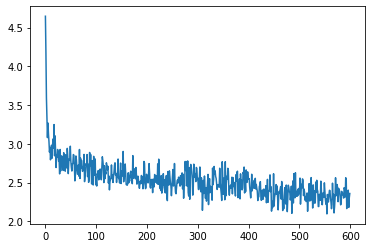

In [50]:
plt.figure()
plt.plot(all_losses)

In [51]:
print(evaluate('м', 50, 0.6), '\n')

может просто на просто проболем полему просто полед 



In [52]:
LOSS = all_losses[-1]
PATH = "checkpoint2.pt"

torch.save({
            'epoch': EPOCH,
            'model_state_dict': decoder.state_dict(),
            'optimizer_state_dict': decoder_optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)
